In [ ]:
import cv2
from skimage.metrics import mean_squared_error, normalized_root_mse, structural_similarity, peak_signal_noise_ratio
import csv
import os
import matplotlib.pyplot as plt
import math
import imutils
import numpy as np
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from sklearn.preprocessing import normalize


from keras import applications
from tensorflow.keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import LSTM
import glob
# from scipy.misc.pilutil import imread,imresize

from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU

from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
Original=[]
# Brightness=[]
# Multiple=[]
# RGB=[]
# Rotation=[]
# Scaling=[]
# Shearing=[]
# Flipping=[]
l=["Brightness","RGB","Rotation","Scaling","Shearing","Flipping"]
l2=[]
for i in range(1,7):
  for j in range(1,6):
    l2.append(l[i-1]+"_"+str(j))

d = dict.fromkeys(l2,[])
d["Multiple_1"]=[]
d["Multiple_4"]=[]

In [ ]:
root = os.path.join(os.getcwd(), 'gdrive/MyDrive/Tampered Video Dataset')

for folder in os.listdir(root):
    cwd = os.path.join(root + '/' + folder)
    print(cwd)
    
    # os.mkdir(folder)
    print(folder)
    if folder == "Original":
      for File in os.listdir(cwd):
        cap = cv2.VideoCapture(os.path.join(root +'/'+folder+ '/'+ File)) 
        i=0
        print(File)
        print(cap.isOpened())
        while(cap.isOpened()):
          retn,frame= cap.read()
          if retn!=True:
            break
          if i%math.floor(5)==0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resized = cv2.resize(frame, (224,224), interpolation = cv2.INTER_AREA)
            Original.append(resized)
            
          i+=1
        cap.release()
        cv2.destroyAllWindows()
         
            

/content/gdrive/MyDrive/Tampered Video Dataset/video_pro2
video_pro2
/content/gdrive/MyDrive/Tampered Video Dataset/video_pro1
video_pro1
/content/gdrive/MyDrive/Tampered Video Dataset/video_pro4
video_pro4
/content/gdrive/MyDrive/Tampered Video Dataset/video_pro5
video_pro5
/content/gdrive/MyDrive/Tampered Video Dataset/video_pro3
video_pro3
/content/gdrive/MyDrive/Tampered Video Dataset/Original
Original
video_pro1.avi
True
video_pro5.avi
True
video_pro3.avi
True
video_pro2.avi
True
video_pro4.avi
True


In [ ]:
for folder in os.listdir(root):
    cwd = os.path.join(root + '/' + folder)
    # print(cwd)
    # os.mkdir(folder)
    # print(folder)
    if folder != "Original":

      for sub_folder in os.listdir(cwd):
        # print(sub_folder)
        cwd2=os.path.join(root + '/' + folder+"/"+sub_folder)
        cnt=0
        for File in os.listdir(cwd2):
          cap = cv2.VideoCapture(os.path.join(root + '/'+folder+'/' +sub_folder+'/'+ File)) 
          i=0
          while(cap.isOpened()):
            retn,frame= cap.read()
            if retn!=True:
              break
            if i%math.floor(25)==0:
              frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
              resized = cv2.resize(frame, (224,224), interpolation = cv2.INTER_AREA)
              d[sub_folder+"_"+folder[-1]].append(resized)
            
            i+=1
          cap.release()
          cv2.destroyAllWindows()
              

          
            

In [ ]:
Brightness=[d["Brightness_1"],d["Brightness_2"],d["Brightness_3"],d["Brightness_4"],d["Brightness_5"]]
Shearing=[d["Shearing_1"],d["Shearing_2"],d["Shearing_3"],d["Shearing_4"],d["Shearing_5"]]
Scaling=[d["Scaling_1"],d["Scaling_2"],d["Scaling_3"],d["Scaling_4"],d["Scaling_5"]]
RGB=[d["RGB_1"],d["RGB_2"],d["RGB_3"],d["RGB_4"],d["RGB_5"]]
Rotation=[d["Rotation_1"],d["Rotation_2"],d["Rotation_3"],d["Rotation_4"],d["Rotation_5"]]
Flipping=[d["Flipping_1"],d["Flipping_2"],d["Flipping_3"],d["Flipping_4"],d["Flipping_5"]]
Multiple=[d["Multiple_1"],d["Multiple_4"]]

In [ ]:
def getMse(img1,img2):
	return mean_squared_error(img1,img2)

In [ ]:
def getPSNR(img1,img2):
	return peak_signal_noise_ratio(img1,img2)

In [ ]:
def getHistCompare(img1,img2):
	hist1 = cv2.calcHist([img1],[0],None,[256],[0,256])
	hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])
	return cv2.compareHist(hist1,hist2,3)

In [ ]:
def getSSIM(img1,img2):
	grayA = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
	grayB = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
	(score, diff) = structural_similarity(grayA, grayB, full=True)
	diff = (diff * 255).astype("uint8")
	return score,diff

In [ ]:
def getEntropy(img1,img2):
	im = cv2.absdiff(img1,img2)
	return sum(sum(sum(im)))

In [ ]:
def getFeatures(img1,img2):
  

  ssim,diffImg = getSSIM(img1,img2)
  features ={}
  features['mse']=getMse(img1,img2)
  features['psnr']=getPSNR(img1,img2)
  features['histogram_compare'] = getHistCompare(img1,img2)
  features['ssim']=ssim
  features['entropy']=getEntropy(img1,img2)
  return features

In [ ]:
def getTrainingFiles():
  xtrain = []
  ytrain = []
  for x in range(0,len(Brightness)-1):
    for y in range(0,len(Brightness[x])-1):

      featureSet=getFeatures(Brightness[x][y],Brightness[x][y+1])
      feature = []
      feature.append(featureSet['mse'])
      feature.append(featureSet['psnr'])
      feature.append(featureSet['histogram_compare'])
      feature.append(featureSet['ssim'])
      feature.append(featureSet['entropy'])
    
      xtrain.append(feature)
      ytrain.append(1)

  for x in range(0,len(Original)-1):
    featureSet=getFeatures(Original[x],Original[x+1])
    feature = []
    feature.append(featureSet['mse'])
    feature.append(featureSet['psnr'])
    feature.append(featureSet['histogram_compare'])
    feature.append(featureSet['ssim'])
    feature.append(featureSet['entropy'])
 
    xtrain.append(feature)
    ytrain.append(0)
    
  xtrain = np.array(xtrain,dtype=object)	
  xtrain = normalize(xtrain, norm='l2') 
  return xtrain,ytrain

In [ ]:
def svm(xtrain,ytrain):
	model = SVC()
	model.fit(xtrain, ytrain)
	print(model.score(xtrain,ytrain))
	# pred = model.predict(xtest)
	# ct=0
	# for i in pred:
	# 	if i==1:
	# 		return 1
	# return 0
x_train,y_train=getTrainingFiles()
svm(x_train,y_train)

0.9204844655081622


In [ ]:
def logisticRegression(xtrain,ytrain):
	model1 = LogisticRegression()
	model1.fit(xtrain, ytrain)
	print(model1.score(xtrain, ytrain))
	# pred = model.predict(xtest)
	# ct=0
	# for i in pred:
	# 	if i==1:
	# 		return 1
	# return 0
logisticRegression(x_train,y_train)

0.9204844655081622


Epoch 1/5
190/190 [==============================] - 1s 3ms/step - loss: 0.5252 - accuracy: 0.7981 - val_loss: 0.3139 - val_accuracy: 0.9200
Epoch 2/5
190/190 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.9206 - val_loss: 0.2746 - val_accuracy: 0.9200
Epoch 3/5
190/190 [==============================] - 0s 2ms/step - loss: 0.2735 - accuracy: 0.9206 - val_loss: 0.2744 - val_accuracy: 0.9200
Epoch 4/5
190/190 [==============================] - 0s 2ms/step - loss: 0.2737 - accuracy: 0.9206 - val_loss: 0.2744 - val_accuracy: 0.9200
Epoch 5/5
190/190 [==============================] - 0s 2ms/step - loss: 0.2733 - accuracy: 0.9206 - val_loss: 0.2746 - val_accuracy: 0.9200


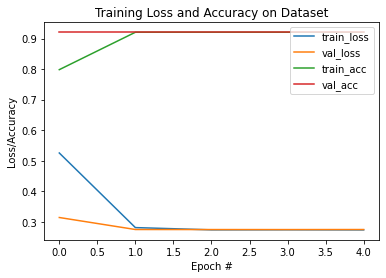

In [ ]:
def neuralNetwork(xtrain,ytrain):
	(trainX, testX, trainY, testY) = train_test_split(xtrain, ytrain, test_size=0.25, stratify=ytrain, random_state=42)
	model = Sequential()
	model.add(Dense(12, input_dim=len(xtrain[0]), activation='relu'))
	model.add(Dense(8, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	H=model.fit(trainX,trainY,validation_data=(testX,testY), epochs=5, batch_size=15) 
	plt.figure()
	plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, 5), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy on Dataset")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="upper right")
	
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
neuralNetwork(x_train,y_train)

In [ ]:
def getdlTrainingFiles():
  labels=[]
  X=[]
  for x in range(0,len(Brightness)-1):
    for y in range(0,len(Brightness[x])-1):
      X.append(Brightness[x][y])
      labels.append(1)
  
  for x in range(0,len(Original)-1):
    X.append(Original[x])
    labels.append(0)
  return X,labels



In [ ]:
X_train,Y_train = getdlTrainingFiles()

def train_test_splitting():
  (trainX, testX, trainY, testY) = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)
  return trainX,testX,trainY,testY

X_train,X_test,Y_train,Y_test=train_test_splitting()

In [ ]:



def CNNRNN():
  baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

  headModel = baseModel.output
  frame_features_input = keras.Input((18, 875))(headModel)
  mask_input = keras.Input((18,), dtype="bool")

  
  x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)(headModel)
  x = keras.layers.GRU(8)(headModel)
  x = keras.layers.Dropout(0.4)(headModel)
  x = keras.layers.Dense(8, activation="relu")
  output = keras.layers.Dense(len(1), activation="softmax")(headModel)

  rnn_model = keras.Model([frame_features_input, mask_input], output)

  rnn_model.compile(
      loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
  )
  return rnn_model


  plt.figure()
  plt.plot(np.arange(0, 3), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, 3), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, 3), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, 3), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend(loc="lower left")


(6643, 224, 224, 3)
(6643,)
(2215, 224, 224, 3)
(2215,)
training head...
Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


207/207 [==============================] - 1246s 6s/step - loss: 0.1753 - accuracy: 0.9664 - val_loss: 0.1538 - val_accuracy: 0.9657
Epoch 2/3
207/207 [==============================] - 933s 5s/step - loss: 0.1739 - accuracy: 0.9659
Epoch 3/3
207/207 [==============================] - 868s 4s/step - loss: 0.1654 - accuracy: 0.9656


ValueError: ignored

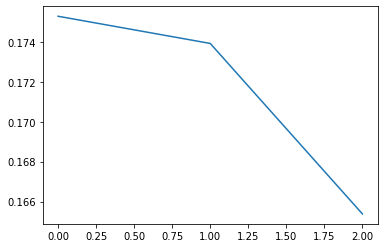

In [ ]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
CNNRNN()

In [ ]:
len(Brightness)

5

In [ ]:
len(Brightness[4])

875

In [ ]:
import shutil
shutil.rmtree("Original")
shutil.rmtree("video_pro1")
shutil.rmtree("video_pro2")
shutil.rmtree("video_pro3")
shutil.rmtree("video_pro4")
shutil.rmtree("video_pro5")
# shutil.rmtree("video_pro6")